In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

Modified timestamps for file handwritingData_1727517549959.svc:
0      0
1    145
2    250
3    335
4    430
Name: timestamp, dtype: int32




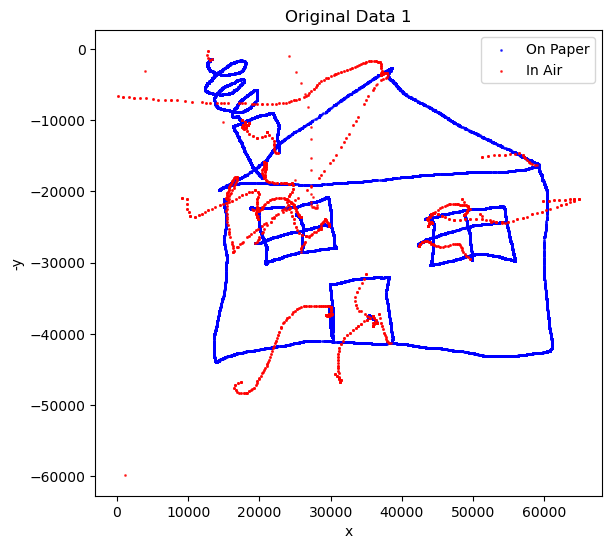

Number of processed files: 1
Average number of data points: 33643


In [2]:
# Cell 2

def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    # If num_files_to_use is specified, only take that many files sequentially
    if num_files_to_use:
        svc_files = svc_files[:num_files_to_use]  # Take the first num_files_to_use files

    data_frames = []  # Processed data after scaling
    original_data_frames = []  # Save the original unscaled data
    scalers = []
    input_filenames = []  # List to store input filenames

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        input_filenames.append(filename)  # Store the filename
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        # Keep a copy of the original data before scaling
        original_data_frames.append(df.copy())  # Save the original unmodified data
        
        # Process the data for use in the model
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        # Plot with a 90-degree right rotation (swap x and y)
        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(on_paper['x'], -on_paper['y'], c='blue', s=1, alpha=0.7, label='On Paper')  # Swap x and y, negate y
        axs[i].scatter(in_air['x'], -in_air['y'], c='red', s=1, alpha=0.7, label='In Air')  # Swap x and y, negate y
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('x')  # x-axis is 'x'
        axs[i].set_ylabel('-y')  # y-axis is '-y'
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames  # Return original data

directory = '../uploads'  # Directory where the .svc files are stored
num_files_to_use = 1
data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)

# Store the name of the first file for use in Cell 4
input_filename = input_filenames[0] if input_filenames else 'processed_data'
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")


In [3]:
# Cell 3
# Process each DataFrame instead of just the first one
for df_idx in range(len(data_frames)):
    df = data_frames[df_idx]  # Using each DataFrame in the list

    # Convert the 'timestamp' column to numeric for calculations (if not already done)
    df['timestamp'] = pd.to_numeric(df['timestamp'])

    # Sort the DataFrame by timestamp (should already be sorted in the function)
    df.sort_values('timestamp', inplace=True)

    # Calculate the differences between consecutive timestamps (optional for gap finding)
    df['time_diff'] = df['timestamp'].diff()

    # Identify the indices where the time difference is greater than 30,000 milliseconds
    gap_indices = df.index[df['time_diff'] > 30000].tolist()

    # Create an empty list to hold the new rows
    new_rows = []

    # Fill in the gaps with 70 milliseconds intervals
    for idx in gap_indices:
        # Check if the next index is valid
        if idx + 1 < len(df):
            # Get the current and next timestamps
            current_timestamp = df.at[idx, 'timestamp']
            next_timestamp = df.at[idx + 1, 'timestamp']

            # Calculate how many entries we need to fill in
            num_fill_entries = (next_timestamp - current_timestamp) // 20000

            # Generate the timestamps to fill the gap
            for i in range(1, num_fill_entries + 1):
                new_timestamp = current_timestamp + i * 70

                # Create a new row to fill in with NaN for x and y
                new_row = {
                    'x': np.nan,  # Set x to NaN
                    'y': np.nan,  # Set y to NaN
                    'timestamp': new_timestamp,
                    'pen_status': 0,        # You can set this to your desired value
                    'azimuth': df.at[idx, 'azimuth'],   # Use the current azimuth value
                    'altitude': df.at[idx, 'altitude'], # Use the current altitude value
                    'pressure': df.at[idx, 'pressure']  # Use the current pressure value
                }

                # Append the new row to the list of new rows
                new_rows.append(new_row)

    # Create a DataFrame from the new rows
    new_rows_df = pd.DataFrame(new_rows)

    # Concatenate the original DataFrame with the new rows DataFrame
    df = pd.concat([df, new_rows_df], ignore_index=True)

    # Sort the DataFrame by timestamp to maintain order
    df.sort_values('timestamp', inplace=True)

    # Reset index after sorting
    df.reset_index(drop=True, inplace=True)

    # Interpolate NaN values in 'x' and 'y' columns based on nearest neighbors
    # Check for NaN entries before interpolation
    if df[['x', 'y']].isnull().any().any():
        df[['x', 'y']] = df[['x', 'y']].interpolate(method='linear')

    # Drop the 'time_diff' column after processing
    df.drop(columns=['time_diff'], inplace=True)

    # Update the processed data
    data_frames[df_idx] = df

# Update processed data for all DataFrames
processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                  for df, scaler in zip(data_frames, scalers)]
avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

In [4]:

# Cell 4
processed_dataframes = []

for input_filename, df in zip(input_filenames, data_frames):
    # Convert all numeric columns to integers
    df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']] = df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']].astype(int)
    
    # Append the processed DataFrame to the list
    processed_dataframes.append(df)

    print(f"Processed DataFrame for: {input_filename}")



Processed DataFrame for: handwritingData_1727517549959.svc


In [5]:
# Cell 5 (modified, no visualization)
def process_dataframes(dataframes, num_files_to_use=None):
    if num_files_to_use:
        dataframes = dataframes[:num_files_to_use]

    data_frames = []
    scalers = []

    for i, df in enumerate(dataframes):
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for DataFrame {i + 1}:")
        print(df['timestamp'].head())
        print("\n")

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, [f"DataFrame_{i+1}" for i in range(len(dataframes))]

# Use the processed_dataframes directly
data_frames, processed_data, scalers, avg_data_points, original_filenames = process_dataframes(processed_dataframes, num_files_to_use)
print(f"Number of processed files: {len(processed_data)}")
# print(f"Average number of data points: {avg_data_points}")


Modified timestamps for DataFrame 1:
0      0
1    145
2    250
3    335
4    430
Name: timestamp, dtype: int32


Number of processed files: 1


In [6]:
# Cell 6 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0, **kwargs):  # Added **kwargs to handle extra arguments
        super(VAE, self).__init__(**kwargs)  # Pass kwargs to the parent class
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),  # 4 for x, y, timestamp, pen_status
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)  # 4 for x, y, timestamp, pen_status
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])  # x, y, and timestamp
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

    @classmethod
    def from_config(cls, config):
        # Handle any unexpected keys like 'trainable' by removing them
        config.pop('trainable', None)
        config.pop('dtype', None)  # Also remove 'dtype' if included
        return cls(**config)

    def get_config(self):
        config = super(VAE, self).get_config()
        # Add the VAE-specific arguments
        config.update({
            'latent_dim': self.latent_dim,
            'beta': self.beta
        })
        return config


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)


# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


# Parameters for VAE
latent_dim = 128
beta = 0.0001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [7]:
# Cell 7 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, processed_data, base_latent_variability=1.0, latent_variability_range=(0.5, 2.0)):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        selected_data = processed_data[i % num_input_files]
        
        # Retain original columns for pressure, azimuth, and altitude
        original_data = data_frames[i % num_input_files]  # Use original unprocessed data
        pressure_azimuth_altitude = original_data[['pressure', 'azimuth', 'altitude']].values
        
        # Determine the number of points for this augmented dataset
        # num_points = int(avg_data_points * (1 + np.random.uniform(-length_variability, length_variability)))
        latent_variability = base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1])
        
        # Encode and reparameterize
        mean, logvar = model.encode(tf.convert_to_tensor(selected_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar * latent_variability)
        
        augmented_data = model.decode(z).numpy()
        
        # # Adjust number of points
        # if num_points > augmented_data.shape[0]:
        #     extra_indices = np.random.choice(augmented_data.shape[0], num_points - augmented_data.shape[0])
        #     augmented_data = np.vstack((augmented_data, augmented_data[extra_indices]))
        # elif num_points < augmented_data.shape[0]:
        #     keep_indices = np.random.choice(augmented_data.shape[0], num_points, replace=False)
        #     augmented_data = augmented_data[keep_indices]

        # Post-process pen status
        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        
        # Ensure timestamps are in sequence
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        
        # Append the pressure, azimuth, and altitude columns from the original data
        augmented_data = np.column_stack((augmented_data, pressure_azimuth_altitude[:augmented_data.shape[0]]))
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/20: 100%|██████████| 67/67 [00:13<00:00,  5.06batch/s, Generator Loss=0.000843, Reconstruction Loss=0.000393, KL Loss=4.5]


Epoch 1: Generator Loss = 0.001373, Reconstruction Loss = 0.001022, KL Divergence Loss = 3.502488
NRMSE = 0.228423


Epoch 2/20: 100%|██████████| 67/67 [00:03<00:00, 21.87batch/s, Generator Loss=0.000929, Reconstruction Loss=0.000504, KL Loss=4.25]


Epoch 2: Generator Loss = 0.001163, Reconstruction Loss = 0.000811, KL Divergence Loss = 3.513820
NRMSE = 0.228879


Epoch 3/20: 100%|██████████| 67/67 [00:02<00:00, 27.86batch/s, Generator Loss=0.000979, Reconstruction Loss=0.000561, KL Loss=4.18]


Epoch 3: Generator Loss = 0.001065, Reconstruction Loss = 0.000715, KL Divergence Loss = 3.497491
NRMSE = 0.228840


Epoch 4/20: 100%|██████████| 67/67 [00:03<00:00, 19.30batch/s, Generator Loss=0.00117, Reconstruction Loss=0.000728, KL Loss=4.39] 


Epoch 4: Generator Loss = 0.000992, Reconstruction Loss = 0.000645, KL Divergence Loss = 3.476446
NRMSE = 0.229204


Epoch 5/20: 100%|██████████| 67/67 [00:03<00:00, 18.39batch/s, Generator Loss=0.000831, Reconstruction Loss=0.000401, KL Loss=4.3] 


Epoch 5: Generator Loss = 0.000941, Reconstruction Loss = 0.000595, KL Divergence Loss = 3.458179
NRMSE = 0.228931


Epoch 6/20: 100%|██████████| 67/67 [00:03<00:00, 17.64batch/s, Generator Loss=0.000767, Reconstruction Loss=0.000376, KL Loss=3.91]


Epoch 6: Generator Loss = 0.000946, Reconstruction Loss = 0.000607, KL Divergence Loss = 3.385814
NRMSE = 0.229678


Epoch 7/20: 100%|██████████| 67/67 [00:03<00:00, 18.72batch/s, Generator Loss=0.00109, Reconstruction Loss=0.000673, KL Loss=4.13] 


Epoch 7: Generator Loss = 0.000837, Reconstruction Loss = 0.000502, KL Divergence Loss = 3.349299
NRMSE = 0.229961


Epoch 8/20: 100%|██████████| 67/67 [00:02<00:00, 22.41batch/s, Generator Loss=0.0045, Reconstruction Loss=0.00407, KL Loss=4.27]   


Epoch 8: Generator Loss = 0.000820, Reconstruction Loss = 0.000489, KL Divergence Loss = 3.312716
NRMSE = 0.230228


Epoch 9/20: 100%|██████████| 67/67 [00:02<00:00, 28.19batch/s, Generator Loss=0.000616, Reconstruction Loss=0.000215, KL Loss=4.01]


Epoch 9: Generator Loss = 0.000780, Reconstruction Loss = 0.000455, KL Divergence Loss = 3.250026
NRMSE = 0.230714


Epoch 10/20: 100%|██████████| 67/67 [00:02<00:00, 22.52batch/s, Generator Loss=0.000612, Reconstruction Loss=0.000231, KL Loss=3.81]


Epoch 10: Generator Loss = 0.000661, Reconstruction Loss = 0.000339, KL Divergence Loss = 3.221353
NRMSE = 0.230282


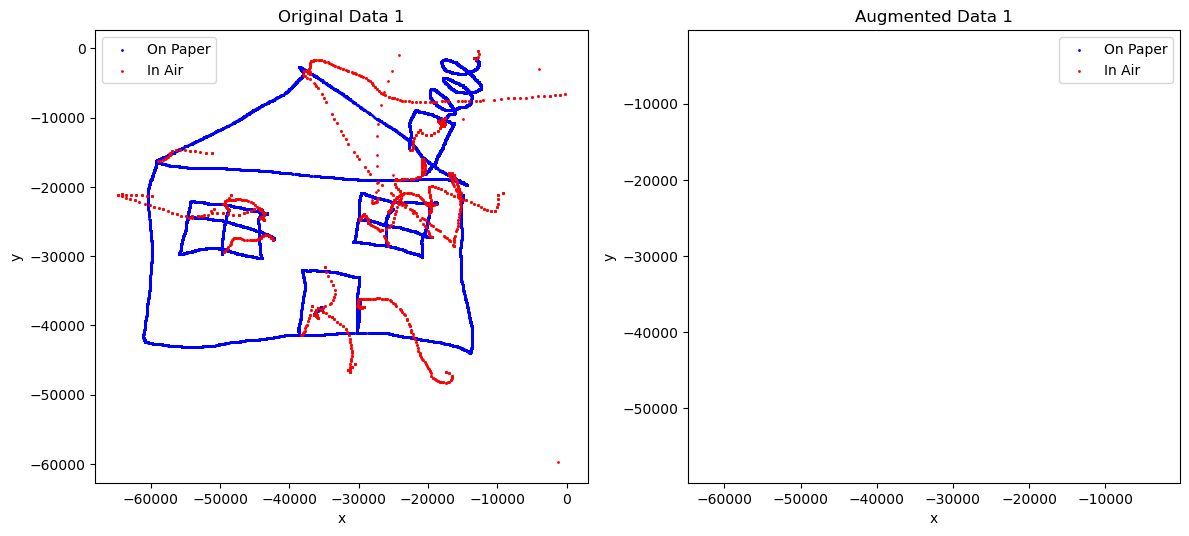

Epoch 11/20: 100%|██████████| 67/67 [00:03<00:00, 22.23batch/s, Generator Loss=0.0005, Reconstruction Loss=0.000126, KL Loss=3.74]  


Epoch 11: Generator Loss = 0.000645, Reconstruction Loss = 0.000327, KL Divergence Loss = 3.177778
NRMSE = 0.230363


Epoch 12/20: 100%|██████████| 67/67 [00:03<00:00, 21.48batch/s, Generator Loss=0.00047, Reconstruction Loss=0.000106, KL Loss=3.63] 


Epoch 12: Generator Loss = 0.000592, Reconstruction Loss = 0.000278, KL Divergence Loss = 3.142411
NRMSE = 0.229972


Epoch 13/20: 100%|██████████| 67/67 [00:03<00:00, 21.08batch/s, Generator Loss=0.000686, Reconstruction Loss=0.000314, KL Loss=3.71]


Epoch 13: Generator Loss = 0.000563, Reconstruction Loss = 0.000251, KL Divergence Loss = 3.120495
NRMSE = 0.230692


Epoch 14/20: 100%|██████████| 67/67 [00:03<00:00, 19.48batch/s, Generator Loss=0.00058, Reconstruction Loss=0.000209, KL Loss=3.71] 


Epoch 14: Generator Loss = 0.000549, Reconstruction Loss = 0.000240, KL Divergence Loss = 3.083536
NRMSE = 0.230587


Epoch 15/20: 100%|██████████| 67/67 [00:03<00:00, 20.06batch/s, Generator Loss=0.000531, Reconstruction Loss=0.000194, KL Loss=3.36]


Epoch 15: Generator Loss = 0.000526, Reconstruction Loss = 0.000222, KL Divergence Loss = 3.038087
NRMSE = 0.230537


Epoch 16/20:  58%|█████▊    | 39/67 [00:02<00:01, 19.47batch/s, Generator Loss=0.000465, Reconstruction Loss=0.000144, KL Loss=3.21]


KeyboardInterrupt: 

In [9]:
#Cell 8
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        # Add LSTM discriminator loss if available
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            generator_loss = reconstruction_loss + total_kl_loss + 0.1 * discriminator_loss  # Adjust the weight as needed
        else:
            generator_loss = reconstruction_loss + total_kl_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 512
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 100
lstm_interval = 10
epochs = 20
visual_per_num_epoch = 10
num_augmented_files = 1

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                # Use LSTM discriminator after vae_epochs and every lstm_interval
                use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({'Generator Loss': float(generator_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train the LSTM discriminator every lstm_interval epochs after vae_epochs
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)  # Reshape for LSTM input
            generated_data = tf.expand_dims(augmented_data, axis=0)

            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')

    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate NRMSE
    nrmse_sum = 0
    for data in processed_data:
        augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
        rmse = np.sqrt(mean_squared_error(data[:, :2], augmented_data[:, :2]))
        nrmse = rmse / (data[:, :2].max() - data[:, :2].min())
        nrmse_sum += nrmse
    
    nrmse_avg = nrmse_sum / len(processed_data)

    nrmse_history.append(nrmse_avg)

    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"NRMSE = {nrmse_avg:.6f}")

    # Cell 5 (visualization part)
    if (epoch + 1) % visual_per_num_epoch == 0:
        base_latent_variability = 100.0
        latent_variability_range = (0.1, 5.0)
        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, 
                                                    base_latent_variability, latent_variability_range)

        # Calculate actual latent variabilities and lengths used
        latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
        augmented_lengths = [len(data) for data in augmented_datasets]

        # Visualize the original and augmented data side by side
        fig, axs = plt.subplots(1, num_augmented_files + len(original_data_frames), figsize=(6*(num_augmented_files + len(original_data_frames)), 6))
        
        for i, original_df in enumerate(original_data_frames):
            original_on_paper = original_df[original_df['pen_status'] == 1]
            original_in_air = original_df[original_df['pen_status'] == 0]
            
            # Apply 180-degree rotation (negating both x and y axes)
            axs[i].scatter(-original_on_paper['x'], -original_on_paper['y'], c='b', s=1, label='On Paper')
            axs[i].scatter(-original_in_air['x'], -original_in_air['y'], c='r', s=1, label='In Air')
            axs[i].set_title(f'Original Data {i+1}')
            axs[i].set_xlabel('x')
            axs[i].set_ylabel('y')
            axs[i].set_aspect('equal')
            axs[i].legend()

        # Set consistent axis limits for square aspect ratio
        x_min = min(df['x'].min() for df in original_data_frames)
        x_max = max(df['x'].max() for df in original_data_frames)
        y_min = min(df['y'].min() for df in original_data_frames)
        y_max = max(df['y'].max() for df in original_data_frames)

        for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
            
            # Apply 180-degree rotation (negating both x and y axes)
            axs[i + len(original_data_frames)].scatter(-augmented_on_paper[:, 0], -augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i + len(original_data_frames)].scatter(-augmented_in_air[:, 0], -augmented_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i + len(original_data_frames)].set_title(f'Augmented Data {i+1}')
            axs[i + len(original_data_frames)].set_xlabel('x')
            axs[i + len(original_data_frames)].set_ylabel('y')
            axs[i + len(original_data_frames)].set_aspect('equal')
            axs[i + len(original_data_frames)].set_xlim(-x_max, -x_min)  # Adjust limits for 180-degree rotation
            axs[i + len(original_data_frames)].set_ylim(-y_max, -y_min)  # Adjust limits for 180-degree rotation
            axs[i + len(original_data_frames)].legend()

        plt.tight_layout()
        plt.show()



# Final output of metrics
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

vae.save('pentab_saved_model.h5')
print("VAE model saved.")

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot NRMSE history
plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pretrained VAE model loaded.


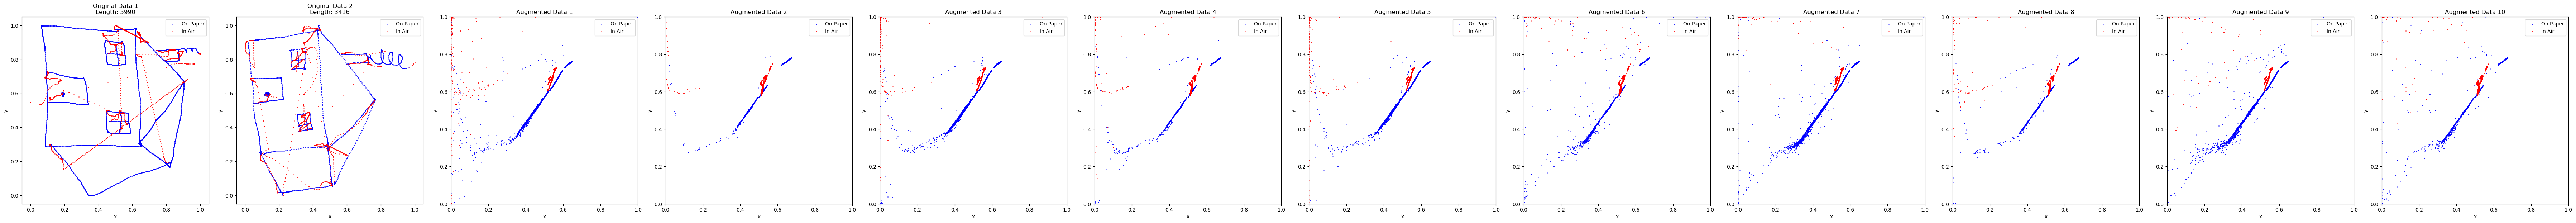

In [18]:
# Cell 9
# Load the pretrained VAE model
with custom_object_scope({'VAE': VAE}):
    vae_pretrained = load_model('pentab_saved_model.h5')
print("Pretrained VAE model loaded.")
base_latent_variability = 100.0
latent_variability_range = (0.1, 5.0)
# length_variability = 0.05
num_augmented_files = 10
# Generate augmented data using the pretrained model
augmented_datasets = generate_augmented_data(vae_pretrained, num_augmented_files, avg_data_points, processed_data, 
                                             base_latent_variability, latent_variability_range)

# Calculate actual latent variabilities and lengths used
latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
augmented_lengths = [len(data) for data in augmented_datasets]

# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, num_augmented_files + len(processed_data), figsize=(6*(num_augmented_files + len(processed_data)), 6))

for i, original_data in enumerate(processed_data):
    original_on_paper = original_data[original_data[:, 3] == 1]
    original_in_air = original_data[original_data[:, 3] == 0]
    axs[i].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
    axs[i].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
    axs[i].set_title(f'Original Data {i+1}\nLength: {len(original_data)}')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].set_aspect('equal')
    axs[i].legend()

# Set consistent axis limits for square aspect ratio
x_min = min(data[:, 0].min() for data in processed_data)
x_max = max(data[:, 0].max() for data in processed_data)
y_min = min(data[:, 1].min() for data in processed_data)
y_max = max(data[:, 1].max() for data in processed_data)

for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
    augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
    augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
    axs[i+len(processed_data)].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
    axs[i+len(processed_data)].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
    axs[i+len(processed_data)].set_title(f'Augmented Data {i+1}')
    axs[i+len(processed_data)].set_xlabel('x')
    axs[i+len(processed_data)].set_ylabel('y')
    axs[i+len(processed_data)].set_aspect('equal')
    axs[i+len(processed_data)].set_xlim(x_min, x_max)
    axs[i+len(processed_data)].set_ylim(y_min, y_max)
    axs[i+len(processed_data)].legend()

plt.tight_layout()
plt.show()

In [1]:
# Cell 10
def download_augmented_data_as_integers(augmented_datasets, scaler, original_data_frames, original_filenames, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, original_df, original_filename) in enumerate(zip(augmented_datasets, original_data_frames, original_filenames)):
        # Ensure the arrays have matching sizes by trimming the larger one
        min_rows = min(len(augmented_data), len(original_df))
        
        # Trim augmented_data if necessary
        augmented_data_trimmed = augmented_data[:min_rows, :]

        # Trim original_df if necessary
        original_df_trimmed = original_df.iloc[:min_rows]

        # Reconstruct the original columns and round to nearest whole number
        augmented_data_original_scale = np.column_stack((
            np.rint(scaler.inverse_transform(augmented_data_trimmed[:, :3])).astype(int),  # Round and convert to integers: x, y, timestamp
            augmented_data_trimmed[:, 3].astype(int),  # Pen status (binary, ensure it's integer 0 or 1)
            np.rint(original_df_trimmed[['pressure', 'azimuth', 'altitude']].values).astype(int)  # Round pressure, azimuth, altitude to integers
        ))

        # Construct the new file name to match the original file name
        augmented_filename = f"augmented_{original_filename}"
        augmented_file_path = os.path.join(directory, augmented_filename)

        # Save the augmented data to a file
        np.savetxt(augmented_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')

        print(f"Augmented data saved to {augmented_file_path}")

# Example call to the function
download_augmented_data_as_integers(augmented_datasets, scalers[0], original_data_frames, input_filenames)


NameError: name 'augmented_datasets' is not defined

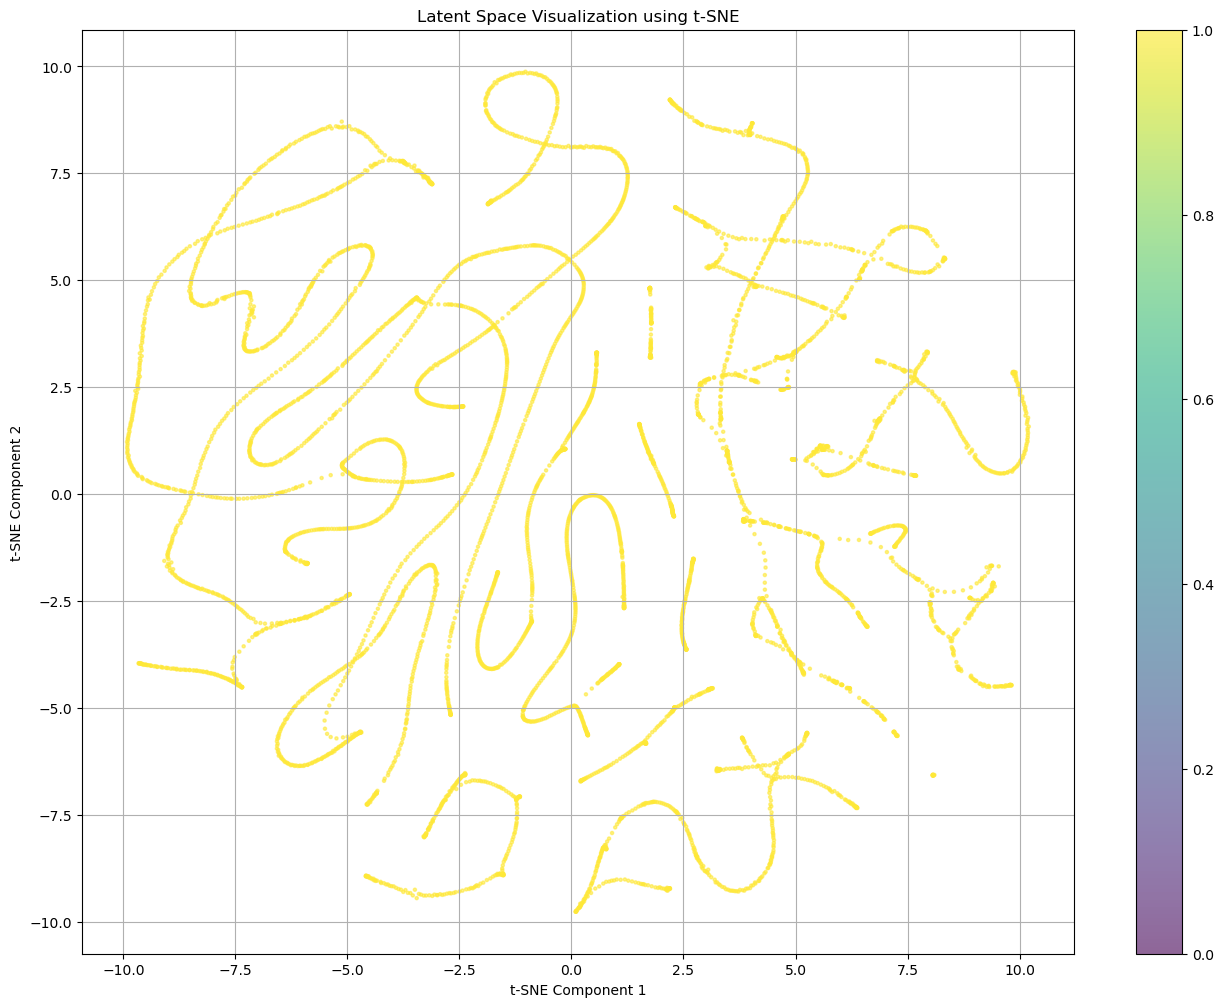

In [22]:
#Cell 11 Function to visualize the latent space with a color gradient
from sklearn.manifold import TSNE

def visualize_latent_space(model, data, perplexity=5, learning_rate=200, n_iter=250):
    # Encode data into the latent space
    latent_means, _ = model.encode(tf.convert_to_tensor(data, dtype=tf.float32))
    latent_means_np = latent_means.numpy()
    
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    latent_2d = tsne.fit_transform(latent_means_np)
    
    # Create a color map for the latent points
    norm = plt.Normalize(vmin=np.min(latent_means_np), vmax=np.max(latent_means_np))
    cmap = plt.cm.cividis  # You can change the colormap to 'plasma', 'inferno', etc.
    colors = cmap(norm(latent_means_np).sum(axis=1))  # Coloring based on the sum of latent variables
    
    # Plot the 2D t-SNE result with the color map
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=5, alpha=0.6)
    plt.colorbar(scatter)  # Add a color bar for the gradient
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize latent space for one of the processed datasets
visualize_latent_space(vae, processed_data[0])